In [106]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json 
import math 

# Data and Main Variables

In [107]:
models = [
    "jinaai/jina-embeddings-v3",
    "Snowflake/snowflake-arctic-embed-l-v2.0", 
    "BAAI/bge-m3", 
    'sentence-transformers/all-MiniLM-L6-v2', 
    'sentence-transformers/all-mpnet-base-v2', 
    'Qwen/Qwen3-Embedding-0.6B', 
    'google/embeddinggemma-300m',
]

In [108]:
df = pd.read_parquet("data/embeddings/unclean_data/speech_embeddings.parquet")
vocab_df = pd.read_parquet("data/embeddings/unclean_data/vocab_embeddings (1).parquet")

color_maps = {
    "party": json.load(open("color_maps/color_map_eu_party.json")), 
    "block": json.load(open("color_maps/color_map_party_blocks.json"))
}

In [109]:
from scripts.preprocessing import remove_non_party_speeches, rename_party_duplicates, add_party_orientation_year_agenda 

def process_df(df): 
    for step in [remove_non_party_speeches, add_party_orientation_year_agenda, rename_party_duplicates, ]: 
        df = step(df) 

    return df

In [110]:
df.rename(columns={"eu_party": "party"}, inplace=True)
df = process_df(df)

Removing speakers without party: 0 (0.00)


In [111]:
df = df[(df['text'].str.len() < 1_300) & (df['text'].str.len() > 700)]
df = df[df["year"] > 2012]

In [112]:
def medioid(embedding): 
    embedding = np.stack(embedding)
    rsm = embedding @ embedding.T 
    most_representative_index = np.argmax(np.sum(rsm, axis=1))
    return embedding[most_representative_index, :]

def mean(embedding): 
    return np.stack(embedding).mean(axis=0)

In [113]:
EMBEDDING_COLUMN = models[5]
AGGREGATION_VARIABLE = "block"
AGGREGATION_METHOD = mean
color_map = color_maps[AGGREGATION_VARIABLE]

Total n: 3889


Text(0.5, 1.0, 'Number of speeches per party and year (total: 3889)')

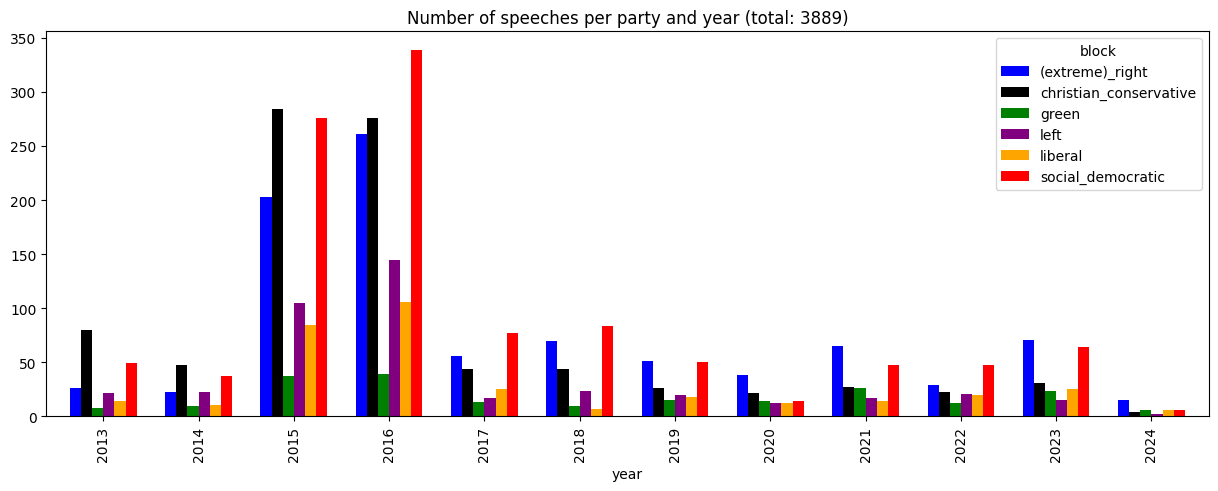

In [114]:
print("Total n:", len(df))
ax = df.groupby(["year", AGGREGATION_VARIABLE]).size().unstack().plot(kind="bar", stacked=False, figsize=(15, 5), width=0.7, color=color_map)
ax.set_title(f"Number of speeches per party and year (total: {len(df)})")
# ax.set_yscale("log")

# Helper Functions

In [115]:
def get_aggregated_embeddings_for_each_year(df: pd.DataFrame, embedding_column: str, aggregate_on: str, embedding_agg_method=mean):
    yearly_data = df.copy()
    yearly_data['year'] = pd.to_datetime(df['date']).dt.year
    aggregated_embeddings = yearly_data.groupby(by=[aggregate_on, 'year'])[embedding_column].agg(embedding_agg_method)
    return aggregated_embeddings.reset_index()

# Patterns over time

## PCA based shifts

In [116]:
from sklearn.decomposition import PCA


aggregated = get_aggregated_embeddings_for_each_year(df, EMBEDDING_COLUMN, AGGREGATION_VARIABLE, AGGREGATION_METHOD)
pca = PCA(n_components=2)
reduced = pca.fit_transform(np.stack(aggregated[EMBEDDING_COLUMN]))
print("PCA explained variance:", pca.explained_variance_.sum())

PCA explained variance: 0.012243432


In [117]:
import re
vocab = list(df['text'].str.split().explode().apply(lambda word: {"cleared": re.sub(r'\W+', '', word).lower(),
                                                                      "original": word}))

In [118]:
cleaned_to_original = {pair['cleared']: pair['original'] for pair in vocab}

In [119]:
def closest_words_for_pc(k, eigen_vectors, vocab, probe_embs, top_n=20):
    pc_vec = eigen_vectors[k]
    pc_vec = pc_vec / np.linalg.norm(pc_vec)
    sims = probe_embs @ pc_vec   

    sorted_indices = np.argsort(sims)
    pos_idx = sorted_indices[-top_n:]
    mid_position = len(sorted_indices)//2
    mid_idx = sorted_indices[mid_position-math.floor(top_n/2) : mid_position+math.ceil(top_n/2)]
    neg_idx = sorted_indices[:top_n]


    def map_indices_to_examples(index_list): 
        if isinstance(vocab, pd.DataFrame) or isinstance(vocab, pd.Series): 
            return [(vocab.iloc[i], sims[i]) for i in index_list]
        else:
            return [(vocab[i], sims[i]) for i in index_list]

    return map_indices_to_examples(neg_idx), map_indices_to_examples(mid_idx), map_indices_to_examples(pos_idx)
    # return ([(vocab[i], sims[i]) for i in neg_idx], [(vocab[i], sims[i]) for i in reversed(pos_idx)])

## Combined

In [120]:
pca_axis_labels = [dict(), dict()]
for axis in [0, 1]: 
    pca_axis_neg, pca_axis_neutr, pca_axis_pos = closest_words_for_pc(axis, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=3)
    pca_axis_labels[axis]["neg"] = pca_axis_neg
    pca_axis_labels[axis]["neutr"] = pca_axis_neutr
    pca_axis_labels[axis]["pos"] = pca_axis_pos

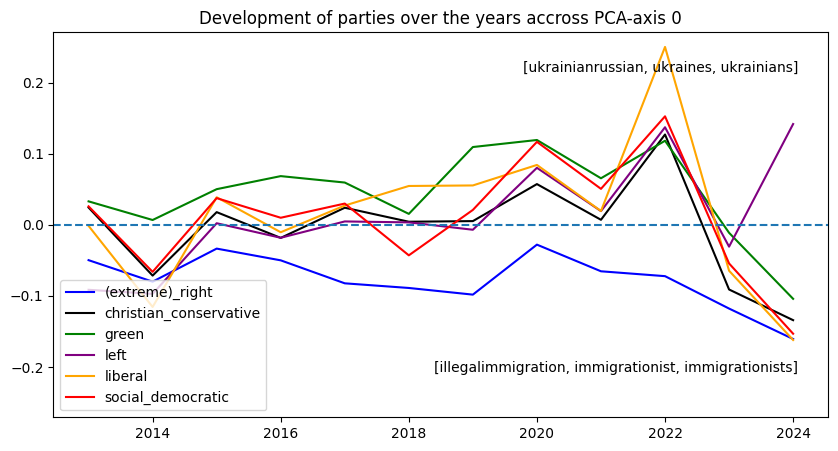

In [121]:
def plot_pca_axis_development(pca_axis):
    # pca_axis_labels = closest_words_for_pc(pca_axis, pca.components_, vocab_df['word'], np.stack(vocab_df[EMBEDDING_COLUMN]), top_n=3)

    f = plt.figure(figsize=(10, 5))
    plt.title(f"Development of parties over the years accross PCA-axis {pca_axis}")

    for party in aggregated[AGGREGATION_VARIABLE].unique():
        party_mask = aggregated[AGGREGATION_VARIABLE] == party
        years = aggregated[party_mask]['year']
        party_embeddings = reduced[party_mask]
        plt.plot(years, party_embeddings[:, pca_axis], color=color_map[party], label=party)

        # plt.ylim()

    max_y_lim = max(abs(plt.ylim()[0]), abs(plt.ylim()[1]))

    plt.ylim((-max_y_lim, max_y_lim))  
    plt.axhline(0, linestyle="--")

    ax_label_neg = ', '.join(map(lambda x: x[0], pca_axis_labels[pca_axis]['neg']))
    # ax_label_neutr = ', '.join(map(lambda x: x[0], pca_axis_labels[pca_axis]['neutr']))
    ax_label_pos = ', '.join(map(lambda x: x[0], pca_axis_labels[pca_axis]['pos']))

    # label for negative axis: 
    plt.figtext(0.87, 0.2, f"[{ax_label_neg}]", horizontalalignment="right")
    # label for positive axis: 
    # plt.figtext(0.87, 0.5, f"[{ax_label_neutr}]", horizontalalignment="right")
    # label for positive axis: 
    plt.figtext(0.87, 0.8, f"[{ax_label_pos}]", horizontalalignment="right")
    plt.legend(loc="lower left")
plot_pca_axis_development(0)


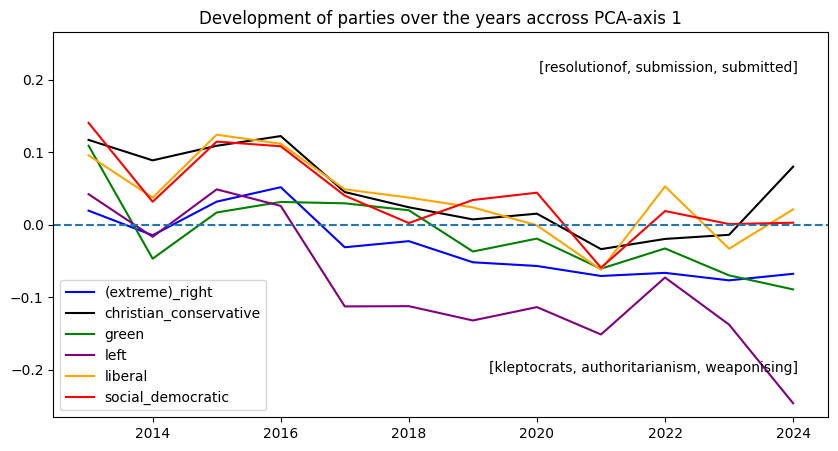

In [122]:
plot_pca_axis_development(1)

## Examples
### First: most extreme in full dataframe

In [123]:
def print_extreme_examlpes(axis, df_group):
    examples = closest_words_for_pc(axis, pca.components_, df_group, np.stack(df_group[EMBEDDING_COLUMN]), top_n=1)

    print(f"Axis {axis} ({list(map(lambda s: s[0], pca_axis_labels[axis]['neg']))} <=> {list(map(lambda s: s[0], pca_axis_labels[axis]['pos']))})")

    for i, polarity in enumerate(["-", "n", "+"]): 
        example = examples[i][0][0]
        similarity = examples[i][0][1]

        print(f"{polarity} score {similarity}: {example['speaker']} ({example['block']}) {example['date']} \n\t'{example['text']}'")

In [124]:
print_extreme_examlpes(0, df)
print("\n")
print_extreme_examlpes(1, df)

Axis 0 (['illegalimmigration', 'immigrationist', 'immigrationists'] <=> ['ukrainianrussian', 'ukraines', 'ukrainians'])
- score -0.37769871950149536: charlie weimers ((extreme)_right) 2024-04-10 
	'Madam President, colleagues, if you want less migration to Europe, kill this deal. Only three of these legal acts will help in the fight against illegal immigration without sacrificing national sovereignty or imposing costs. The others will incentivise more migration. How will redistribution deter millions and millions of migrants destined to arrive in Europe in the coming decades? It won’t. Instead, the entire EU will mimic Sweden’s migrant problems, gang wars, overrun welfare systems and increasing Islamism all over Europe. Commissioner, you ones on the left won’t be in charge after the elections. Then the centre right can negotiate a deal that stops illegal migration, locates the entire asylum process outside Europe, increases deportations and support frontline Member States without impos

### Now: per party per year

In [125]:
def print_extreme_examlpes_per_block_and_year(group, year, axis): 
    df_group = df[df["block"] == group]
    df_group_year = df_group[df_group["year"] == year]
    
    print("n", len(df_group_year))
    print_extreme_examlpes(axis, df_group_year)

    # per year, get most extreme (pos and negative), and most representative (medioid) 
print_extreme_examlpes_per_block_and_year("left", 2023, axis=1)

n 15
Axis 1 (['kleptocrats', 'authoritarianism', 'weaponising'] <=> ['resolutionof', 'submission', 'submitted'])
- score -0.27543559670448303: mick wallace (left) 2023-03-15 
	'Mr President, we’re talking about 26 000 lives lost in the Mediterranean, and that’s just the number of bodies recovered. God knows what the real figure is. This is not just a tragedy; it is a preventable tragedy. This humanitarian crisis has been created by neglectful and inhumane policies, Member State border pushbacks and the creation of Frontex who have carried out further illegal pushbacks and have been complicit in severe human rights violations. Migrants desperately need safe legal pathways, not arbitrary criminalisation for risking their lives in treacherous conditions for a better future. Remember, many MEPs in here voted for these migrants to drown at sea. Has it dawned on them that maybe these migrants want to leave the jungle and go to the garden of Europe? Because we are doing untold damage to the j